In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

from skopt.benchmarks import branin
from skopt import Optimizer
from pyDOE import *

/Users/nimishawalgaonkar/anaconda2/envs/scikit_optimize_develop/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<Figure size 432x288 with 0 Axes>

In [2]:
def neg_branin(x):
    y = -1*branin(x)
    return y

In [3]:
def plot_branin_with_points(X):
    fig, ax = plt.subplots(figsize = (12,8))

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))
    ax.plot(X[:,0], X[:, 1], "k.", markersize=14, lw=0, label="points")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

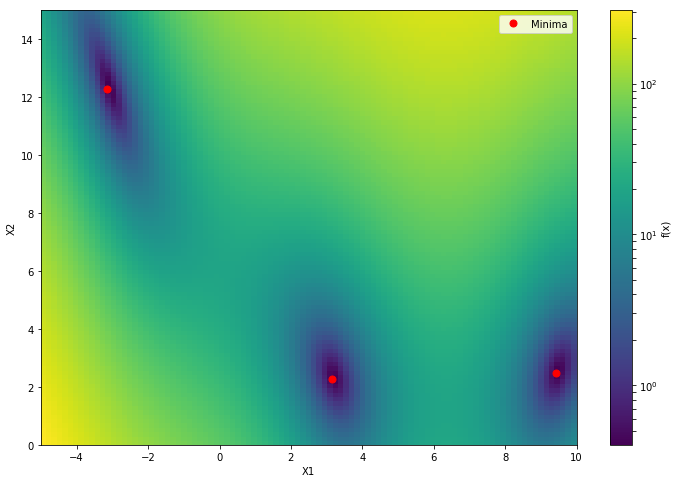

In [4]:
from matplotlib.colors import LogNorm

def plot_branin_with_minima():
    fig, ax = plt.subplots(figsize = (12,8))

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

plot_branin_with_minima()

In [5]:
ntrain = 50 # number of initial training points
d = 2 # number of dimensions of the input features

X_train_norm = lhs(2, samples= ntrain, criterion='maximin') # Initial training points
X_train = np.zeros(X_train_norm.shape)
X_train[:,0] = X_train_norm[:,0]*15 - 5.
X_train[:,1] = X_train_norm[:,1]*15
Y_train = neg_branin(X_train.T)
bounds = [(-5.0, 10.0), (0.0, 15.0)]

In [6]:
opt = Optimizer(bounds, base_estimator="gp", acq_func = 'qEI',
                acq_optimizer = 'sampling', random_state = 123)

qEI aquisition function (parallel BGO) is still under development
----------------------------------------
Right now, it can only be used with sampling acq_optimizer


In [7]:
opt.tell(X_train.tolist(), Y_train.tolist())

we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.


          fun: -218.0782325571445
    func_vals: array([ -38.02139204,   -6.84686835,   -3.84769098,  -46.59864996,
       -106.03068841,  -17.26558586,  -57.94172046,  -12.99403395,
        -37.08600539,  -33.22398312, -138.778057  ,  -44.41353045,
        -20.17648984,  -15.83438464,  -16.37311789,  -21.60955363,
       -177.84822597, -101.88955032,  -59.36459719,  -17.42976814,
        -29.01136075, -137.9990274 ,  -47.63844269,  -15.39186586,
        -28.03105857,  -60.11433157,  -17.99784872, -113.18550174,
        -43.29446292,  -98.12992219,  -26.65863116, -170.3432751 ,
        -30.36408375,  -18.13490032,   -9.10906695,   -3.83218899,
         -6.91201808,   -0.45499341,  -87.91668479,  -53.59800883,
       -171.20195916,  -84.1924601 ,  -26.90390004,  -70.32490478,
       -218.07823256,  -53.36640107,  -39.32534174,  -11.68385873,
        -94.2446718 ,   -3.72747342])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(le

In [8]:
qei_args_dict = {'num_sampled_points': 3,
               'num_batches_eval' : 4000,
               'strategy_batch_selection' : 'random'}
X_new = opt.ask(n_points= None, additional_acq_func_kwargs = qei_args_dict)

In [9]:
opt.x_pending

In [10]:
X_new

[[9.71119260479664, 1.6820030556717889],
 [8.659728115217566, 6.5679101542309395],
 [-3.378527213758302, 12.813421093488039]]

In [11]:
from sklearn.model_selection import train_test_split

def simulate_pending_evals(X_new):
    """
    This is going to simulate pending evaluations which is going to happen in actual scenario.
    Split X_new into X_done and X_pending
    X_done will be evaluate and we get Y_done
    X_pending will be pending
    """
    
    X_done, X_pending = train_test_split(np.array(X_new), test_size = 0.5)
    Y_done = neg_branin(X_done.T)
    return X_pending, X_done, Y_done

In [12]:
X_pending, X_done, Y_done = simulate_pending_evals(X_new)

In [13]:
opt.tell(X_done.tolist(), Y_done.tolist(), X_pending.tolist())

Good to go, do nothing
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.


          fun: -218.0782325571445
    func_vals: array([ -38.02139204,   -6.84686835,   -3.84769098,  -46.59864996,
       -106.03068841,  -17.26558586,  -57.94172046,  -12.99403395,
        -37.08600539,  -33.22398312, -138.778057  ,  -44.41353045,
        -20.17648984,  -15.83438464,  -16.37311789,  -21.60955363,
       -177.84822597, -101.88955032,  -59.36459719,  -17.42976814,
        -29.01136075, -137.9990274 ,  -47.63844269,  -15.39186586,
        -28.03105857,  -60.11433157,  -17.99784872, -113.18550174,
        -43.29446292,  -98.12992219,  -26.65863116, -170.3432751 ,
        -30.36408375,  -18.13490032,   -9.10906695,   -3.83218899,
         -6.91201808,   -0.45499341,  -87.91668479,  -53.59800883,
       -171.20195916,  -84.1924601 ,  -26.90390004,  -70.32490478,
       -218.07823256,  -53.36640107,  -39.32534174,  -11.68385873,
        -94.2446718 ,   -3.72747342,   -0.6676129 ])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1

In [14]:
a = opt.ask(additional_acq_func_kwargs = qei_args_dict)

we are here..abcd


In [15]:
a

[[-2.615303089731382, 12.576115302177142],
 [4.237808756100417, 7.900429098472139],
 [9.882008129516127, 0.30385695046596667]]

In [16]:
opt.best_batch[opt.x_pending.shape[0]:,:]

array([[0.15897979, 0.83840769],
       [0.61585392, 0.52669527],
       [0.99213388, 0.02025713]])

# Full Example

In [17]:
ntrain = 50 # number of initial training points
d = 2 # number of dimensions of the input features

X_train_norm = lhs(2, samples= ntrain, criterion='maximin') # Initial training points
X_train = np.zeros(X_train_norm.shape)
X_train[:,0] = X_train_norm[:,0]*15 - 5.
X_train[:,1] = X_train_norm[:,1]*15
Y_train = neg_branin(X_train.T)
bounds = [(-5.0, 10.0), (0.0, 15.0)]

In [18]:
Xx = X_train
Yy = Y_train

In [19]:
opt = Optimizer(bounds, base_estimator="gp", acq_func = 'qEI',
                acq_optimizer = 'sampling', random_state = 123)

qEI aquisition function (parallel BGO) is still under development
----------------------------------------
Right now, it can only be used with sampling acq_optimizer


In [20]:
def plot_branin_with_points(X):
    fig, ax = plt.subplots(figsize = (12,8))

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))
    ax.plot(X[:,0], X[:, 1], "k.", markersize=14, lw=0, label="points")
    
    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qEI aquisition function ,we are just fitting the model and nothing more.
we are here :: qEI
When tell() is called with qE

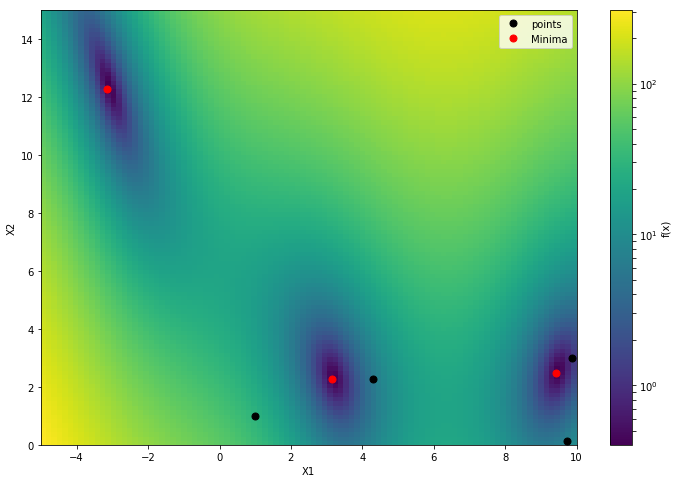

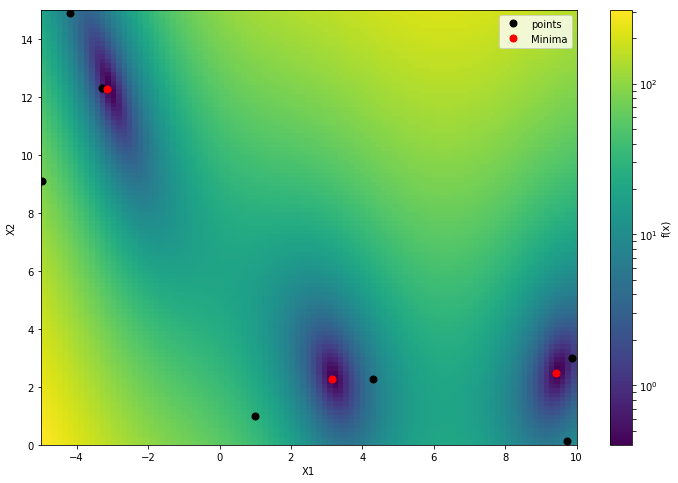

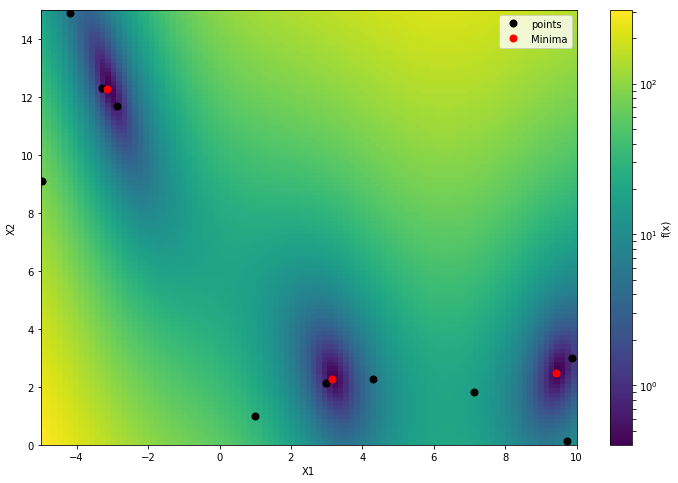

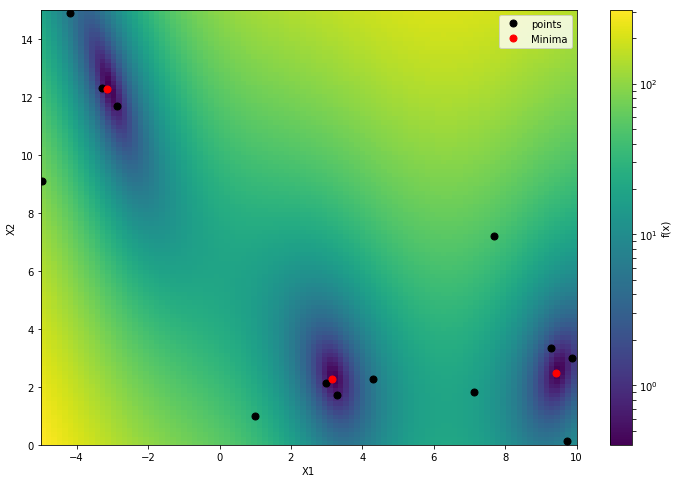

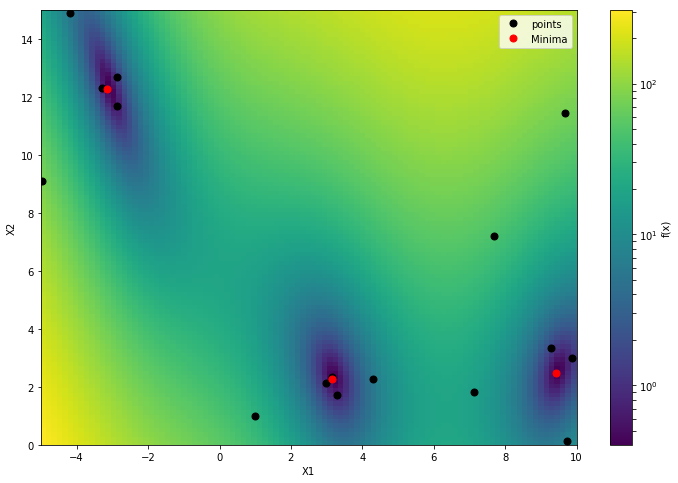

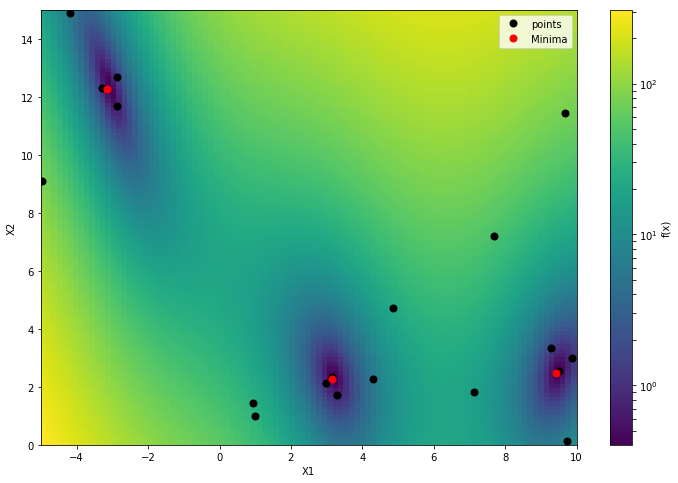

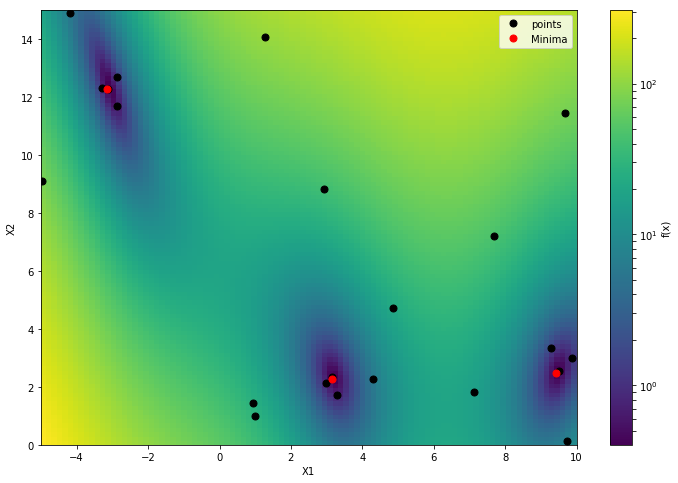

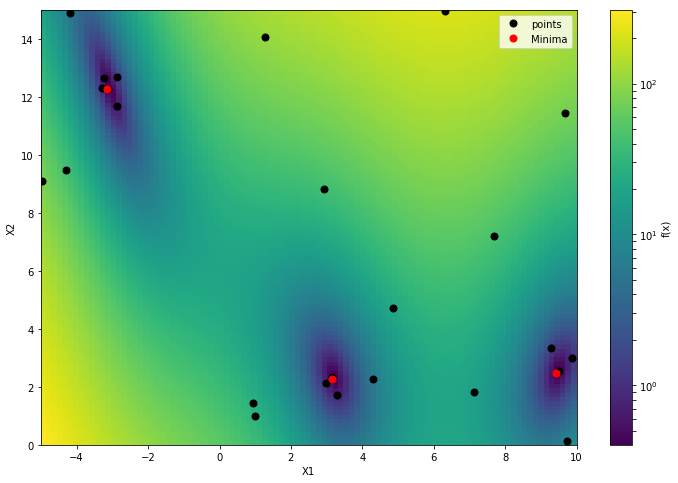

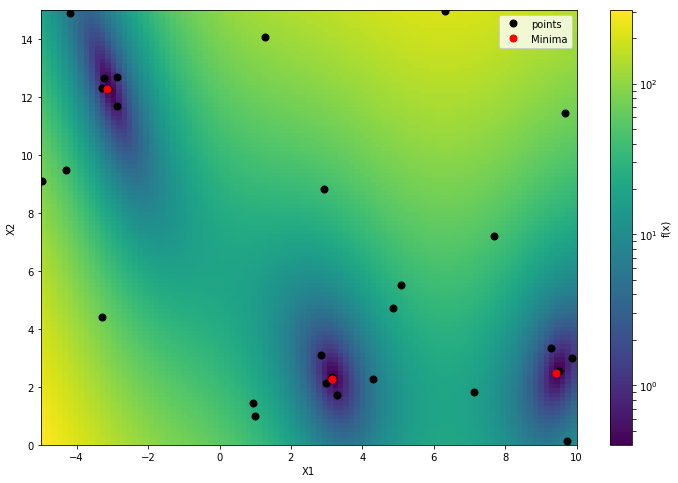

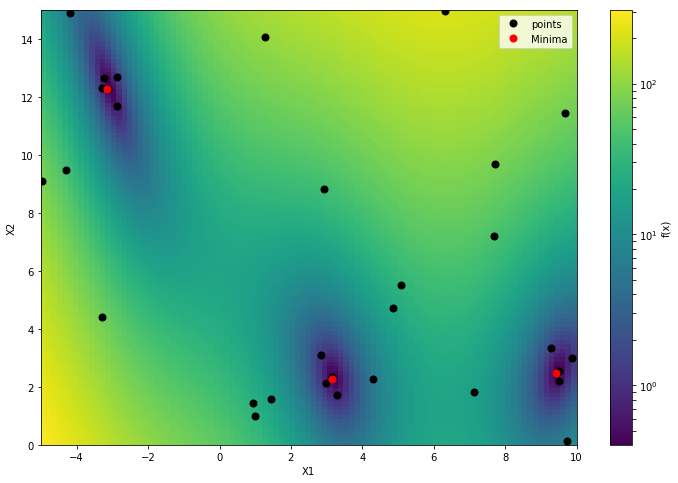

In [21]:
iteration = 10
total_evals = np.empty(shape = 2)
for i in range(iteration):
    opt.tell(Xx.tolist(), Yy.tolist())
    nxt_eval = opt.ask(additional_acq_func_kwargs = qei_args_dict)
    nxt_eval = np.array(nxt_eval)
    Xx = np.vstack([Xx, nxt_eval])
    y = neg_branin(nxt_eval.T)
    Yy = np.append(Yy, y)
    total_evals = np.vstack([total_evals,nxt_eval])
    plot_branin_with_points(total_evals)